<a href="https://colab.research.google.com/github/dunnohow/Bert/blob/master/bluehouseblah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer # load language model & tokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup


import random
import tqdm
import re
import time
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<br>
<br>

#**Load Data (청와대 청원 데이터)**

<br>

https://dacon.io/competitions/open/235597/overview/

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = "drive/My Drive/NLP_practice/Blue-House/"
os.listdir(path)

['train.csv',
 'sample_submission.csv',
 'test.csv',
 'data.csv',
 'bluehouseblah.ipynb']

In [ ]:
# 그래프에 retina display 적용
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [ ]:
train.iloc[:,1].value_counts()

2    13362
1    13337
0    13301
Name: category, dtype: int64

In [ ]:
train.head()

,index,category,data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


In [ ]:
test.head()

,index,data
0,0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."


In [ ]:
bert = BertModel.from_pretrained('bert-base-multilingual-cased').cuda()
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
# 데이터 문장 길이가 다르기 때문에 [PAD] token을 활용해야함, 또한 최대 길이도 정해야함
print(train['data'][0])
print(tokenizer.encode(train['data'][0]))
print(len(tokenizer.encode(train['data'][0])))

신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지 마시고\n보편적으로 모든국민이 수긍할  수 있는 복지정책 펴 주시길 바랍니다.\n저도 신혼부부이지만 당첨되는 사람 로또되는 이런주택정책 반대합니다.\n국민세금을 일부 사람들에게 퍼주기식이 되면 안되죠..\n그 세금으로 우리아이 안전하게 맡길 수 있는 보육시설을 전국에 설치해 주세요..\n대기업들은 솔선수범해서 모든 사업장에 의무설치 할 수 있도록 하시구요..\n집 보다 애 맡길데가 없어 경력단절 되는게 더 괴롭습니다.!\n집은 개인의 능력을 키워 사는게 맞습니다.\n그 능력을 키울수 있도록 육아 전담에 힘을 기울이는게 맞습니다.\n우리아이 부모가 키우는거 맞지만 이제는 국가가\n책임지는 시대로 가는게 맞다고 봅니다.\n그렇잖아도 부동산 가격 자꾸 올라가는게 정부정책이 잘못 되었다고 봅니다.\n부동산은 그냥 내버려 두세요!  좀!\n건들수록 역효과네요..
[101, 9487, 119439, 14646, 14646, 19855, 11102, 9689, 119342, 16605, 119254, 106154, 9356, 83811, 14040, 31928, 9044, 26737, 16323, 24982, 48549, 119, 119, 8909, 36553, 24982, 40032, 11467, 47807, 11513, 28195, 9670, 119254, 119396, 12508, 9246, 14040, 11664, 165, 182, 30005, 50450, 17022, 25701, 20479, 36553, 10739, 9460, 118665, 14843, 9460, 13767, 9357, 12508, 16605, 119254, 9923, 9689, 14040, 118666, 9318, 118853, 48345, 119, 165, 182, 48387, 12092, 9487, 119439, 14646, 14646, 44359, 19105, 9067, 119260, 24683, 9405,

<br>
<br>

#**훈련셋 전처리**

In [ ]:
# 청원 문장 추출
sentences = train['data']
def sentence_clean(text):
    # 스페셜 토큰 추가
    text = ["[CLS] " + str(sentence) + " [SEP]" for sentence in text]
    # 문장 단위"\\n" 제거
    text = [sentence.replace('\\n', '.') for sentence in text]
    text = [sentence.replace('.', ' ') for sentence in text]
    text = [sentence.replace('!', ' ') for sentence in text]
    text = [sentence.replace('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ') for sentence in text]
    text = [tokenizer.tokenize(sent) for sent in text]
    return(text)

tokenized_texts = sentence_clean(sentences)
print(tokenized_texts[0])

['[CLS]', '신', '##혼', '##부', '##부', '##위', '##한', '주', '##택', '##정', '##책', '보다', '보', '##육', '##시', '##설', '늘', '##려', '##주', '##세', '##요', '국', '##민', '##세', '##금', '##으로', '일부', '##를', '위한', '정', '##책', '##펴', '##지', '마', '##시', '##고', '보', '##편', '##적으로', '모든', '##국', '##민', '##이', '수', '##긍', '##할', '수', '있는', '복', '##지', '##정', '##책', '펴', '주', '##시', '##길', '바', '##랍', '##니다', '저', '##도', '신', '##혼', '##부', '##부', '##이지', '##만', '당', '##첨', '##되는', '사', '##람', '로', '##또', '##되는', '이런', '##주', '##택', '##정', '##책', '반', '##대', '##합', '##니다', '국', '##민', '##세', '##금', '##을', '일부', '사', '##람', '##들에게', '퍼', '##주', '##기', '##식', '##이', '되', '##면', '안', '##되', '##죠', '그', '세', '##금', '##으로', '우', '##리아', '##이', '안', '##전', '##하게', '맡', '##길', '수', '있는', '보', '##육', '##시', '##설', '##을', '전', '##국', '##에', '설치', '##해', '주', '##세', '##요', '대', '##기', '##업', '##들은', '솔', '##선', '##수', '##범', '##해서', '모든', '사', '##업', '##장에', '의', '##무', '##설', '##치', '할', '수', '있도록', '하', '##시', '##구', '#

In [ ]:
token_len = np.array([len(sent) for sent in tokenized_texts])
np.quantile([len(sent) for sent in tokenized_texts],0.9)

719.0

(array([3.9422e+04, 4.6200e+02, 7.9000e+01, 2.3000e+01, 8.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.00000e+00, 2.07150e+03, 4.14100e+03, 6.21050e+03, 8.28000e+03,
        1.03495e+04, 1.24190e+04, 1.44885e+04, 1.65580e+04, 1.86275e+04,
        2.06970e+04]),
 <a list of 10 Patch objects>)

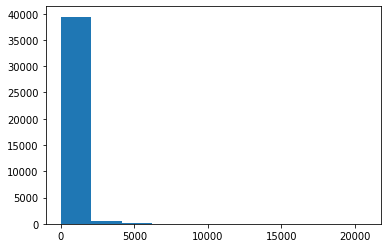

In [ ]:
plt.hist([len(sent) for sent in tokenized_texts])

In [ ]:
trim = train.iloc[np.where(token_len < 719)[0],:]
trim.head()

,index,category,data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


In [ ]:
labels = trim['category']
labels.value_counts()

1    12410
2    11798
0    11791
Name: category, dtype: int64

In [ ]:
sentences = trim['data']
tokenized_texts = sentence_clean(sentences)
print(tokenized_texts[0])

['[CLS]', '신', '##혼', '##부', '##부', '##위', '##한', '주', '##택', '##정', '##책', '보다', '보', '##육', '##시', '##설', '늘', '##려', '##주', '##세', '##요', '국', '##민', '##세', '##금', '##으로', '일부', '##를', '위한', '정', '##책', '##펴', '##지', '마', '##시', '##고', '보', '##편', '##적으로', '모든', '##국', '##민', '##이', '수', '##긍', '##할', '수', '있는', '복', '##지', '##정', '##책', '펴', '주', '##시', '##길', '바', '##랍', '##니다', '저', '##도', '신', '##혼', '##부', '##부', '##이지', '##만', '당', '##첨', '##되는', '사', '##람', '로', '##또', '##되는', '이런', '##주', '##택', '##정', '##책', '반', '##대', '##합', '##니다', '국', '##민', '##세', '##금', '##을', '일부', '사', '##람', '##들에게', '퍼', '##주', '##기', '##식', '##이', '되', '##면', '안', '##되', '##죠', '그', '세', '##금', '##으로', '우', '##리아', '##이', '안', '##전', '##하게', '맡', '##길', '수', '있는', '보', '##육', '##시', '##설', '##을', '전', '##국', '##에', '설치', '##해', '주', '##세', '##요', '대', '##기', '##업', '##들은', '솔', '##선', '##수', '##범', '##해서', '모든', '사', '##업', '##장에', '의', '##무', '##설', '##치', '할', '수', '있도록', '하', '##시', '##구', '#

(array([7691., 7836., 6048., 4590., 3149., 2240., 1570., 1232.,  926.,
         717.]),
 array([  2. ,  73.6, 145.2, 216.8, 288.4, 360. , 431.6, 503.2, 574.8,
        646.4, 718. ]),
 <a list of 10 Patch objects>)

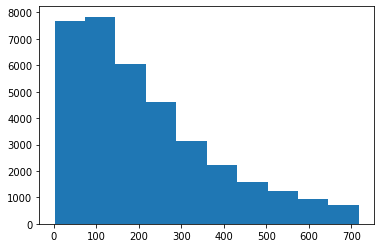

In [ ]:
plt.hist([len(sent) for sent in tokenized_texts])

In [ ]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(len(tokenizer.convert_tokens_to_ids(tokenized_texts[0])))
input_ids[0]

281


array([   101,   9487, 119439,  14646,  14646,  19855,  11102,   9689,
       119342,  16605, 119254, 106154,   9356,  83811,  14040,  31928,
         9044,  26737,  16323,  24982,  48549,   8909,  36553,  24982,
        40032,  11467,  47807,  11513,  28195,   9670, 119254, 119396,
        12508,   9246,  14040,  11664,   9356,  50450,  17022,  25701,
        20479,  36553,  10739,   9460, 118665,  14843,   9460,  13767,
         9357,  12508,  16605, 119254,   9923,   9689,  14040, 118666,
         9318, 118853,  48345,   9663,  12092,   9487, 119439,  14646,
        14646,  44359,  19105,   9067, 119260,  24683,   9405,  61250,
         9202, 118839,  24683,  80956,  16323, 119342,  16605, 119254,
         9321,  14423,  33188,  48345,   8909,  36553,  24982,  40032,
        10622,  47807,   9405,  61250,  61688,   9913,  16323,  12310,
        21155,  10739,   9098,  14867,   9521, 118800, 119217,   8924,
         9435,  40032,  11467,   9604,  31065,  10739,   9521,  16617,
      

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=7, 
                                                                                    test_size=0.2)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=7, 
                                                       test_size=0.2)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels.values)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels.values)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9095,  17138, 119439,  10622,   9957,  33768,  18227,   9960,
         16323, 119085,  14040,  28188,   9095,  17138, 119439,  10622,   9321,
         14423,  12178,  30050,   8924,   9651,  29683,  11261,   9095,  17138,
        119121,  13764,  27023,  10530,  18154,   9730,  61844,  58303,  48345,
          9365,  14646,  92413,    117,   9487, 119439,   9365,  14646,  92413,
          9032,  85836,   9460,  13767,   9672,  12092,  14801,   9984, 119342,
         10622,   9095,  17138, 119121,  13764,  60362,  89184,   8932,  14863,
         20626,  23466,   9330,  17730,  24683,  30050,   9730,  61844,  58303,
         48345,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
batch_size = 16

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<br>
<br>

#**Test set pre-processing**

In [ ]:
# 청원 문장 추출
sentences = test['data']
# 스페셜 토큰 추가
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
# 문장 단위"\\n" 제거
sentences = [sentence.replace('\\n', '.') for sentence in sentences]
sentences = [sentence.replace('.', ' ') for sentence in sentences]
sentences = [sentence.replace('!', ' ') for sentence in sentences]
sentences = [sentence.replace('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ') for sentence in sentences]
sentences[:10]

['[CLS] 소년법 폐지해주세요  법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하고 있습니다 오히려 법을 악용하는 사례만 늘어나고 그 강도는 높아지고 있습니다 소년법폐지를 부탁드립니다 [SEP]',
 '[CLS] 국공립 유치원 증설에 관하여  국공립 유치원 부지 학보와건립및 증설에 *지역 어린이 놀이터 부지와 지역의 방대한 주민센터휴계부지 및 구청 시청 군청 청사공간부지 활용과 청년실업과 퇴직희망자가 재교육을 통해  유아 유치 업무에 종사하는 방법은 불가능한 건가요 [SEP]',
 '[CLS] 나경원파면  나경원의원의  동계올림픽 위원을 파면해 주세요 [SEP]',
 '[CLS] 국민위원에가 삼성편만들어요  삼성에서 11년간  일하고 혈암과 백혈병 진단을 받은 사람이 많아요~  그래서 산업 제외을 받기 위해서 환경 평가표을 받아야 합니다 ~  그래야 신청 할 수 있습니다 ~ 법원에서도 평가표을 공개하라고 판결이 나지만   국가 국민위원에가 공개을 하지 못하겠 하고 있어요~ 삼성이 환경평간표가 산업 기밀 이라고 다시 막았어요~ 단 하루만에 피해자들은 11년동안 고통을 받고 있는데           제발  국민위원에가  국민을 위해  일해주세요 그리고 국민위원에서 독단으로  처리한 분도 다시 감독 해주세요 [SEP]',
 '[CLS] 방과후,유치원,어린이집 영어교육을 유지시켜주세요  저는 아이 셋 키우는 평범한 주부입니다 학교 방과후나 어린이집에서 받는 영어교육은 과하지않은 도움되는 교육이라 좋은점을 많이 느끼고 있는데 이렇게 없앤다고 하니 막막한 생각이 듭니다 학원을 보내기쉽지않은 경제상태인데 많은 시간을 배정받은 것도 아닌데   저처럼 도움받는 분들이 더욱 많은것으로 알고있는데 상황도 모르고 높은분들은 그저 토론 후 없애버리고있습니다   영어를 쉽게 놀이처럼 받아들이며 배우는 작은 지역에서의 영어교육은 서울 수도권처럼 과하지않습니다   영어유치원 원어민 선생님과 공부하는것도 아니고 소규모지역 부모들은 이 작은 교육도 지금 받지 못하게 됐어요 서

In [ ]:
labels = [0] *5000

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

[CLS] 소년법 폐지해주세요  법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하고 있습니다 오히려 법을 악용하는 사례만 늘어나고 그 강도는 높아지고 있습니다 소년법폐지를 부탁드립니다 [SEP]
['[CLS]', '소', '##년', '##법', '폐', '##지', '##해', '##주', '##세', '##요', '법', '아', '##래', '##에서', '보', '##호', '##받', '##아', '##야', '할', '아', '##이', '##들이', '법', '##으로', '인해', '보', '##호', '##받', '##지', '못', '##하고', '있', '##습', '##니다', '오', '##히', '##려', '법', '##을', '악', '##용', '##하는', '사', '##례', '##만', '늘', '##어', '##나', '##고', '그', '강', '##도는', '높', '##아', '##지고', '있', '##습', '##니다', '소', '##년', '##법', '##폐', '##지를', '부', '##탁', '##드', '##립', '##니다', '[SEP]']


In [ ]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9448,  10954,  33768,   9927,  12508,  14523,  16323,
        24982,  48549,   9341,   9519,  37388,  11489,   9356,  20309,
       118965,  16985,  21711,   9955,   9519,  10739,  20173,   9341,
        11467,  39629,   9356,  20309, 118965,  12508,   9290,  12453,
         9647, 119081,  48345,   9580,  18108,  26737,   9341,  10622,
         9520,  24974,  12178,   9405,  58762,  19105,   9044,  12965,
        16439,  11664,   8924,   8853,  60884,   9028,  16985,  68833,
         9647, 119081,  48345,   9448,  10954,  33768, 119399,  36908,
         9365, 119335,  15001,  35115,  48345,    102,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   9448,  10954,  33768,   9927,  12508,  14523,  16323,  24982,
         48549,   9341,   9519,  37388,  11489,   9356,  20309, 118965,  16985,
         21711,   9955,   9519,  10739,  20173,   9341,  11467,  39629,   9356,
         20309, 118965,  12508,   9290,  12453,   9647, 119081,  48345,   9580,
         18108,  26737,   9341,  10622,   9520,  24974,  12178,   9405,  58762,
         19105,   9044,  12965,  16439,  11664,   8924,   8853,  60884,   9028,
         16985,  68833,   9647, 119081,  48345,   9448,  10954,  33768, 119399,
         36908,   9365, 119335,  15001,  35115,  48345,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
#batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
#test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_sampler = RandomSampler(test_data)
#test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

<br>
<br>

#**Modeling**

In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 10

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **Model Learning**

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.cuda() for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.3f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch   500  of  1,800.    Elapsed: 0:01:52.
  Batch 1,000  of  1,800.    Elapsed: 0:03:43.
  Batch 1,500  of  1,800.    Elapsed: 0:05:35.

  Average training loss: 0.25
  Training epcoh took: 0:06:43

Running Validation...
  Accuracy: 0.858
  Validation took: 0:00:27

======== Epoch 2 / 10 ========
Training...
  Batch   500  of  1,800.    Elapsed: 0:01:53.
  Batch 1,000  of  1,800.    Elapsed: 0:03:45.
  Batch 1,500  of  1,800.    Elapsed: 0:05:37.

  Average training loss: 0.19
  Training epcoh took: 0:06:44

Running Validation...
  Accuracy: 0.852
  Validation took: 0:00:27

======== Epoch 3 / 10 ========
Training...
  Batch   500  of  1,800.    Elapsed: 0:01:52.
  Batch 1,000  of  1,800.    Elapsed: 0:03:45.
  Batch 1,500  of  1,800.    Elapsed: 0:05:38.

  Average training loss: 0.20
  Training epcoh took: 0:06:46

Running Validation...
  Accuracy: 0.852
  Validation took: 0:00:27

======== Epoch 4 / 10 ========
Training...
  Batch   5

<br>
<br>

# **테스트셋 평가**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences([sentences[10]])
print(np.argmax(logits))

1


In [ ]:
logits = test_sentences([sentences[9]])

print(logits)
print(np.argmax(logits))

[[-3.0210195 -2.9451287  5.7414165]]
2


In [ ]:
%time
category = [None]
for i in range(len(sentences)):
  logits = test_sentences([sentences[i]])
  category.append(np.argmax(logits))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


In [ ]:
category = category[1:]

(array([1741.,    0.,    0.,    0.,    0., 1659.,    0.,    0.,    0.,
        1600.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

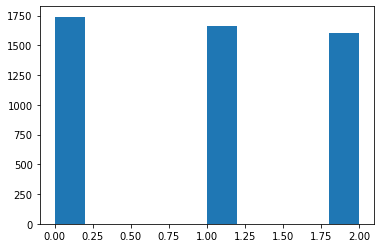

In [ ]:
%matplotlib inline 
plt.hist(category)

#**후처리 작업**


- pre-truncate: not good
- reduce batch size: slightly better


In [ ]:
sample_sent = train['data'][5000:6000]
sample_sent = np.array(sample_sent)
sample_lab = train['category'][5000:6000]
sample_lab = np.array(sample_lab)
sample_sent = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sample_sent]
sample_sent = [sentence.replace('\\n', ' ') for sentence in sample_sent]
sample_sent = [sentence.replace('.', ' ') for sentence in sample_sent]
sample_sent = [sentence.replace('?', ' ') for sentence in sample_sent]
sample_sent = [sentence.replace('!', ' ') for sentence in sample_sent]

In [ ]:
%time
sample_category = [None]
for i in range(len(sample_sent)):
  temp = test_sentences([sample_sent[i]])
  sample_category.append(np.argmax(temp))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.39 µs


In [ ]:
sample_category = sample_category[1:]

(array([325.,   0.,   0.,   0.,   0., 324.,   0.,   0.,   0., 351.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

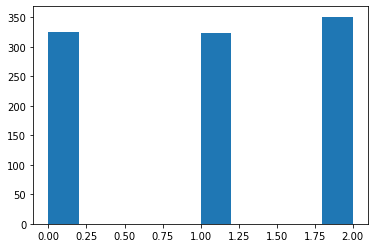

In [ ]:
%matplotlib inline 
plt.hist(sample_category)

In [ ]:
temp = 0
for i in range(len(sample_category)):
    if sample_category[i] != sample_lab[i]: 
      temp = temp + 1
      print('Row: {}, Actual Category: {}, Predicted Category: {}, Number of different rows: {}'.format(i, sample_lab[i], sample_category[i], temp))

Row: 6, Actual Category: 0, Predicted Category: 2, Number of different rows: 1
Row: 28, Actual Category: 1, Predicted Category: 0, Number of different rows: 2
Row: 29, Actual Category: 2, Predicted Category: 0, Number of different rows: 3
Row: 71, Actual Category: 2, Predicted Category: 0, Number of different rows: 4
Row: 82, Actual Category: 0, Predicted Category: 2, Number of different rows: 5
Row: 133, Actual Category: 2, Predicted Category: 0, Number of different rows: 6
Row: 157, Actual Category: 1, Predicted Category: 0, Number of different rows: 7
Row: 177, Actual Category: 0, Predicted Category: 1, Number of different rows: 8
Row: 178, Actual Category: 2, Predicted Category: 0, Number of different rows: 9
Row: 181, Actual Category: 2, Predicted Category: 0, Number of different rows: 10
Row: 187, Actual Category: 2, Predicted Category: 0, Number of different rows: 11
Row: 195, Actual Category: 0, Predicted Category: 1, Number of different rows: 12
Row: 205, Actual Category: 1, P

In [ ]:
confusion_matrix(sample_lab, sample_category)

array([[301,   6,  10],
       [  9, 317,   3],
       [ 15,   1, 338]])

In [ ]:
test_sentences([sample_sent[4]])

array([[-1.1471677, -4.3579984,  5.4787016]], dtype=float32)

#**Out File**

In [ ]:
from google.colab import files

In [ ]:
output = pd.DataFrame(category, columns=['category'])
output['index'] = output.index
output = output.iloc[:,[1,0]]
print(output.head())

   index  category
0      0         2
1      1         2
2      2         1
3      3         0
4      4         2


In [ ]:
output.to_csv('data.csv')
!cp data.csv "drive/My Drive/NLP_practice/Blue-House/"